<a href="https://colab.research.google.com/github/zhrv-rscf/tg_2d_cuda/blob/feature-compr/tg2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content/drive/MyDrive/rscf/tg_2d_cuda

/content/drive/MyDrive/rscf/tg_2d_cuda


In [2]:
rm *.vtk *.npz

In [3]:
!git clone https://github.com/rogersce/cnpy.git

Cloning into 'cnpy'...
remote: Enumerating objects: 164, done.
remote: Total 164 (delta 0), reused 0 (delta 0), pack-reused 164
Receiving objects: 100% (164/164), 52.32 KiB | 1.69 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [5]:
%%file tg2d.cu
#include "cnpy/cnpy.h"
#include <cstdlib>
#include <iostream>
#include <cuda.h>
#include <cstring>
#include <cmath>
#include <sstream>
#include <iomanip>

typedef double Real;
typedef int Int;


#define M_E            2.7182818284590452354    /* e */
#define M_LOG2E        1.4426950408889634074    /* log_2 e */
#define M_LOG10E    0.43429448190325182765    /* log_10 e */
#define M_LN2        0.69314718055994530942    /* log_e 2 */
#define M_LN10        2.30258509299404568402    /* log_e 10 */
#define M_PI        3.14159265358979323846    /* pi */
#define M_PI_2        1.57079632679489661923    /* pi/2 */
#define M_PI_4        0.78539816339744830962    /* pi/4 */
#define M_1_PI        0.31830988618379067154    /* 1/pi */
#define M_2_PI        0.63661977236758134308    /* 2/pi */
#define M_2_SQRTPI    1.12837916709551257390    /* 2/sqrt(pi) */
#define M_SQRT2        1.41421356237309504880    /* sqrt(2) */
#define M_SQRT1_2    0.70710678118654752440    /* 1/sqrt(2) */

#define __max__(x, y) ((x) > (y) ? (x) : (y))

#define FLUX_HLLC

#define RECONSTR WENO5
#define FLUX calc_flux_hllc

#define R0 1.0
#define V0 1.0
#define MU 0.01
#define MU_L 0.0
#define NU 0.01

#define GAM  1.4
#define K_WENO  3
#define NX  400
#define NY  400
#define NXG (NX+2*K_WENO)
#define NYG (NY+2*K_WENO)
#define DLO_X 0.0
#define DHI_X (2*M_PI)
#define DLO_Y 0.0
#define DHI_Y (2*M_PI)
#define CFL  0.5
#define DT 1.e-3
#define MAX_TIME 32.

const int SAVE_STEP = 1000;
const int LOG_STEP = 1000;


#define BLOCK_SIZE 4

dim3 threads(BLOCK_SIZE, BLOCK_SIZE);
dim3 grid(NX / threads.x + 1, NY / threads.y + 1);


Real prim_r[NX][NY];
Real prim_u[NX][NY];
Real prim_v[NX][NY];
Real prim_p[NX][NY];
Real prim_e[NX][NY];

Real exact_u[NX][NY];
Real exact_v[NX][NY];
Real exact_p[NX][NY];

struct vec_t {
    Real x;
    Real y;
};

struct cons_t {
    Real ro;
    Real ru;
    Real rv;
    Real re;
};


__forceinline__ void _checkErr(cudaError cuda_err, int _line, std::string _file) {
    if (cuda_err != cudaSuccess) {
        printf("ERROR (file: %s, line: %d): %s \n",
               _file.c_str(), _line, cudaGetErrorString(cuda_err));
        abort();
    }
}

#define checkErr(f) _checkErr( f, __LINE__, __FILE__)



template<typename T>
T *mallocOnDevice(int nx, int ny) {
    T *c;
    cudaError_t result;
    result = cudaMalloc(&c, sizeof(T) * nx * ny);
    checkErr(result);
    return c;
}



template<typename T>
T *mallocOnHost(int nx, int ny) {
    return new T[nx*ny];
}




struct data_t {
    struct {
        cons_t *cons, *cons_old, *fluxx, *fluxy;
        vec_t *grad_u, *grad_v;
        vec_t *x;
    } d;
    struct {
        cons_t *cons;
        vec_t *x;
    } h;
    struct {
        Int step;
        Real t;
        Real hx, hy;
        Real hx2, hy2;
        Real hx_pow2, hy_pow2;
    } g;

    data_t() {
        alloc();
        init_g();
    }

    void alloc() {
        h.cons = malloc_on_host<cons_t>(NXG, NYG);
        h.x = malloc_on_host<vec_t>(NXG, NYG);

        d.cons = mallocOnDevice<cons_t>(NXG, NYG);
        d.cons_old = mallocOnDevice<cons_t>(NXG, NYG);
        d.fluxx = mallocOnDevice<cons_t>(NX + 1, NY);
        d.fluxy = mallocOnDevice<cons_t>(NX, NY + 1);

        d.grad_u = mallocOnDevice<vec_t>(NXG, NYG);
        d.grad_v = malloc_on_device<vec_t>(NXG, NYG);
        d.x = malloc_on_device<vec_t>(NXG, NYG);

    }

    void init_g() {
        g.step = 0;
        g.t = 0.;
        g.hx = (DHI_X - DLO_X) / NX;
        g.hy = (DHI_Y - DLO_Y) / NY;
        g.hx2 = 2.*g.hx;
        g.hy2 = 2.*g.hy;
        g.hx_pow2 = g.hx*g.hx;
        g.hy_pow2 = g.hy*g.hy;
    }

    void copy_to_host() {
        cudaMemcpy(h.cons, d.cons, NXG * NYG * sizeof(cons_t), cudaMemcpyDeviceToHost);
    }

    void copy_coord_to_host() {
        cudaMemcpy(h.x, d.x, NXG * NYG * sizeof(vec_t), cudaMemcpyDeviceToHost);
    }

    void copy_to_old() {
        cudaMemcpy(d.cons_old, d.cons, NXG * NYG * sizeof(cons_t), cudaMemcpyDeviceToDevice);
    }

};


__device__
Real sign(Real x) {
    if (x < 0.) {
        return -1.;
    } else if (x > 0.) {
        return 1.;
    } else {
        return 0.;
    }
}


__device__
Real minmod(Real x, Real y) {
    if (sign(x) != sign(y)) return 0.;
    return sign(x) * (fabs(x) < fabs(y) ? fabs(x) : fabs(y));
}


__device__
void CONST(Real *u, Real &ul, Real &ur) {
    ul = u[K_WENO - 1];
    ur = u[K_WENO];
}


__global__
void init(data_t d) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    int j = blockDim.y * blockIdx.y + threadIdx.y;
    if (i < NX and j < NY) {
        int ii = i + K_WENO;
        int jj = j + K_WENO;
        int idx = jj * NXG + ii;

        Real r, p, u, v;
        d.d.x[idx].x = DLO_X + (i + Real(0.5)) * d.g.hx;
        d.d.x[idx].y = DLO_Y + (j + Real(0.5)) * d.g.hy;

        r = R0;
        u = cos(d.d.x[idx].x) * sin(d.d.x[idx].y);
        v = -sin(d.d.x[idx].x) * cos(d.d.x[idx].y);
        p = 1. - 0.25 * R0 * (cos(2. * d.d.x[idx].x) + cos(2. * d.d.x[idx].y));

        d.d.cons[idx].ro = r;
        d.d.cons[idx].ru = r * u;
        d.d.cons[idx].rv = r * v;
        d.d.cons[idx].re = p / (GAM - 1.) + r * (u * u + v * v) * 0.5;
    }
}


__global__
void fill_boundary(cons_t *cons) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    int j = blockDim.y * blockIdx.y + threadIdx.y;
    int id_src, id_dst;
    if (i < K_WENO and j < NY) {
        id_dst = (K_WENO + j) * NXG + (K_WENO - i - 1);
        id_src = (K_WENO + j) * NXG + (NX + K_WENO - i - 1);
        cons[id_dst].ro = cons[id_src].ro;
        cons[id_dst].ru = cons[id_src].ru;
        cons[id_dst].rv = cons[id_src].rv;
        cons[id_dst].re = cons[id_src].re;
        id_dst = (K_WENO + j) * NXG + (NX + K_WENO + i);
        id_src = (K_WENO + j) * NXG + (K_WENO + i);
        cons[id_dst].ro = cons[id_src].ro;
        cons[id_dst].ru = cons[id_src].ru;
        cons[id_dst].rv = cons[id_src].rv;
        cons[id_dst].re = cons[id_src].re;
    }
    if (i < NX and j < K_WENO) {
        id_dst = (K_WENO - j - 1) * NXG + (K_WENO + i);
        id_src = (NY + K_WENO - j - 1) * NXG + (K_WENO + i);
        cons[id_dst].ro = cons[id_src].ro;
        cons[id_dst].ru = cons[id_src].ru;
        cons[id_dst].rv = cons[id_src].rv;
        cons[id_dst].re = cons[id_src].re;
        id_dst = (NY + K_WENO + j) * NXG + (K_WENO + i);
        id_src = (K_WENO + j) * NXG + (K_WENO + i);
        cons[id_dst].ro = cons[id_src].ro;
        cons[id_dst].ru = cons[id_src].ru;
        cons[id_dst].rv = cons[id_src].rv;
        cons[id_dst].re = cons[id_src].re;
    }
}


__global__
void fill_boundary(vec_t *vec) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    int j = blockDim.y * blockIdx.y + threadIdx.y;
    int id_src, id_dst;
    if (i < K_WENO and j < NY) {
        id_dst = (K_WENO + j) * NXG + (K_WENO - i - 1);
        id_src = (K_WENO + j) * NXG + (NX + K_WENO - i - 1);
        vec[id_dst].x = vec[id_src].x;
        vec[id_dst].y = vec[id_src].y;
        id_dst = (K_WENO + j) * NXG + (NX + K_WENO + i);
        id_src = (K_WENO + j) * NXG + (K_WENO + i);
        vec[id_dst].x = vec[id_src].x;
        vec[id_dst].y = vec[id_src].y;
    }
    if (i < NX and j < K_WENO) {
        id_dst = (K_WENO - j - 1) * NXG + (K_WENO + i);
        id_src = (NY + K_WENO - j - 1) * NXG + (K_WENO + i);
        vec[id_dst].x = vec[id_src].x;
        vec[id_dst].y = vec[id_src].y;
        id_dst = (NY + K_WENO + j) * NXG + (K_WENO + i);
        id_src = (K_WENO + j) * NXG + (K_WENO + i);
        vec[id_dst].x = vec[id_src].x;
        vec[id_dst].y = vec[id_src].y;
    }
}


__device__
void TVD2(Real *u, Real &ul, Real &ur) {
    ul = u[K_WENO - 1] + 0.5 * minmod(u[K_WENO - 1] - u[K_WENO - 2], u[3] - u[K_WENO - 1]);
    ur = u[3] - 0.5 * minmod(u[K_WENO] - u[K_WENO - 1], u[K_WENO + 1] - u[K_WENO]);
}


__device__
void WENO5(Real *u, Real &ul, Real &ur) {
    Real beta[3];
    Real alpha[3];
    Real eps = 1.0e-6;
    if ((u[2] - u[1]) * (u[3] - u[2]) < 0.0) ul = u[2];
    else {
        //значение слева
        beta[0] = (13. / 12.) * (u[2] - 2 * u[3] + u[4]) * (u[2] - 2 * u[3] + u[4]) +
                  0.25 * (3 * u[2] - 4 * u[3] + u[4]) * (3 * u[2] - 4 * u[3] + u[4]);
        beta[1] = (13. / 12.) * (u[1] - 2 * u[2] + u[3]) * (u[1] - 2 * u[2] + u[3]) +
                  0.25 * (u[1] - u[3]) * (u[1] - u[3]);
        beta[2] = (13. / 12.) * (u[0] - 2 * u[1] + u[2]) * (u[0] - 2 * u[1] + u[2]) +
                  0.25 * (u[0] - 4 * u[1] + 3 * u[2]) * (u[0] - 4 * u[1] + 3 * u[2]);
        alpha[0] = 0.3 / ((eps + beta[0]) * (eps + beta[0]));
        alpha[1] = 0.6 / ((eps + beta[1]) * (eps + beta[1]));
        alpha[2] = 0.1 / ((eps + beta[2]) * (eps + beta[2]));
        ul = (alpha[0] * (2 * u[2] + 5 * u[3] - u[4]) + alpha[1] * (-u[1] + 5 * u[2] + 2 * u[3]) +
              alpha[2] * (2 * u[0] - 7 * u[1] + 11 * u[2])) / ((alpha[0] + alpha[1] + alpha[2]) * 6);
    }
    if ((u[3] - u[2]) * (u[4] - u[3]) < 0.0) ur = u[3];
    else {
        //значение справа
        beta[0] = (13. / 12.) * (u[3] - 2 * u[4] + u[5]) * (u[3] - 2 * u[4] + u[5]) +
                  0.25 * (3 * u[3] - 4 * u[4] + u[5]) * (3 * u[3] - 4 * u[4] + u[5]);
        beta[1] = (13. / 12.) * (u[2] - 2 * u[3] + u[4]) * (u[2] - 2 * u[3] + u[4]) +
                  0.25 * (u[2] - u[4]) * (u[2] - u[4]);
        beta[2] = (13. / 12.) * (u[1] - 2 * u[2] + u[3]) * (u[1] - 2 * u[2] + u[3]) +
                  0.25 * (u[1] - 4 * u[2] + 3 * u[3]) * (u[1] - 4 * u[2] + 3 * u[3]);
        alpha[0] = 0.1 / ((eps + beta[0]) * (eps + beta[0]));
        alpha[1] = 0.6 / ((eps + beta[1]) * (eps + beta[1]));
        alpha[2] = 0.3 / ((eps + beta[2]) * (eps + beta[2]));
        ur = (alpha[0] * (11 * u[3] - 7 * u[4] + 2 * u[5]) + alpha[1] * (2 * u[2] + 5 * u[3] - u[4]) +
              alpha[2] * (-u[1] + 5 * u[2] + 2 * u[3])) / ((alpha[0] + alpha[1] + alpha[2]) * 6);
    }
}


#define F_HLLC_U(UK, FK, SK, SS, PK, RK, VK) (((SS)*((SK)*(UK)-(FK)) + (SK)*( (PK)+(RK)*((SK)-(VK))*((SS)-(VK)) )) / ((SK)-(SS)))
#define F_HLLC_V(UK, FK, SK, SS, PK, RK, VK) (((SS)*((SK)*(UK)-(FK))) / ((SK)-(SS)))
#define F_HLLC_E(UK, FK, SK, SS, PK, RK, VK) (((SS)*((SK)*(UK)-(FK)) + (SK)*( (PK)+(RK)*((SK)-(VK))*((SS)-(VK)) )*(SS)) / ((SK)-(SS)))

__device__
void calc_flux_hllc(
        Real rl, Real pl, Real ul, Real vl, Real wl,
        Real rr, Real pr, Real ur, Real vr, Real wr,
        Real &qr, Real &qu, Real &qv, Real &qw, Real &qe) {
    Real sl, sr, p_star, s_star, p_pvrs, _ql, _qr, tmp, e_tot_l, e_tot_r, czl, czr;

    e_tot_l = pl / rl / (GAM - 1.) + 0.5 * (ul * ul + vl * vl + wl * wl);
    e_tot_r = pr / rr / (GAM - 1.) + 0.5 * (ur * ur + vr * vr + wr * wr);

    czl = sqrt(GAM * pl / rl);
    czr = sqrt(GAM * pr / rr);

    p_pvrs = 0.5 * (pl + pr) - 0.5 * (ur - ul) * 0.25 * (rl + rr) * (czl + czr);
    p_star = (p_pvrs > 0.) ? p_pvrs : 0.;

    _ql = (p_star <= pl) ? 1 : sqrt(1. + (GAM + 1.) * (p_star / pl - 1.) / (2. * GAM));
    _qr = (p_star <= pr) ? 1 : sqrt(1. + (GAM + 1.) * (p_star / pr - 1.) / (2. * GAM));

    sl = ul - czl * _ql;
    sr = ur + czr * _qr;

    if (sl > sr) {
        tmp = sl;
        sl = sr;
        sr = tmp;
    }

    s_star = pr - pl;
    s_star += rl * ul * (sl - ul);
    s_star -= rr * ur * (sr - ur);
    s_star /= (rl * (sl - ul) - rr * (sr - ur));

    if (s_star < sl) s_star = sl;
    if (s_star > sr) s_star = sr;


    if (!((sl <= s_star) && (s_star <= sr))) {
//        amrex::Print() << "HLLC: inequality SL <= S* <= SR is FALSE." << "\n";
//        abort();
        return;
    }

    if (sl >= 0.) {
        qr = rl * ul;
        qu = rl * ul * ul + pl;
        qv = rl * vl * ul;
        qw = rl * wl * ul;
        qe = (rl * e_tot_l + pl) * ul;
    } else if (sr <= 0.) {
        qr = rr * ur;
        qu = rr * ur * ur + pr;
        qv = rr * vr * ur;
        qw = rr * wr * ur;
        qe = (rr * e_tot_r + pr) * ur;
    } else {
        if (s_star >= 0) {
            qr = F_HLLC_V( /*  UK, FK, SK, SS, PK, RK, VK */
                    rl,
                    rl * ul,
                    sl, s_star, pl, rl, ul
            );
            qu = F_HLLC_U( /*  UK, FK, SK, SS, PK, RK, VK */
                    rl * ul,
                    rl * ul * ul + pl,
                    sl, s_star, pl, rl, ul
            );
            qv = F_HLLC_V( /*  UK, FK, SK, SS, PK, RK, VK */
                    rl * vl,
                    rl * ul * vl,
                    sl, s_star, pl, rl, ul
            );
            qw = F_HLLC_V( /*  UK, FK, SK, SS, PK, RK, VK */
                    rl * wl,
                    rl * ul * wl,
                    sl, s_star, pl, rl, ul
            );
            qe = F_HLLC_E( /*  UK, FK, SK, SS, PK, RK, VK */
                    rl * e_tot_l,
                    (rl * e_tot_l + pl) * ul,
                    sl, s_star, pl, rl, ul
            );
        } else {
            qr = F_HLLC_V( /*  UK, FK, SK, SS, PK, RK, VK */
                    rr,
                    rr * ur,
                    sr, s_star, pr, rr, ur
            );
            qu = F_HLLC_U( /*  UK, FK, SK, SS, PK, RK, VK */
                    rr * ur,
                    rr * ur * ur + pr,
                    sr, s_star, pr, rr, ur
            );
            qv = F_HLLC_V( /*  UK, FK, SK, SS, PK, RK, VK */
                    rr * vr,
                    rr * ur * vr,
                    sr, s_star, pr, rr, ur
            );
            qw = F_HLLC_V( /*  UK, FK, SK, SS, PK, RK, VK */
                    rr * wr,
                    rr * ur * wr,
                    sr, s_star, pr, rr, ur
            );
            qe = F_HLLC_E( /*  UK, FK, SK, SS, PK, RK, VK */
                    rr * e_tot_r,
                    (rr * e_tot_r + pr) * ur,
                    sr, s_star, pr, rr, ur
            );
        }
    }
}


__global__
void compute_grad(data_t d) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    int j = blockDim.y * blockIdx.y + threadIdx.y;
    if (i < NXG and j < NYG) {
        int id = j * NXG + i;
        int idxp = j * NXG + i + 1;
        int idxm = j * NXG + i - 1;
        int idyp = (j + 1) * NXG + i;
        int idym = (j - 1) * NXG + i;

        d.d.grad_u[id].x = (d.d.cons[idxp].ru / d.d.cons[idxp].ro - d.d.cons[idxm].ru / d.d.cons[idxm].ro) / d.g.hx2;
        d.d.grad_v[id].x = (d.d.cons[idxp].rv / d.d.cons[idxp].ro - d.d.cons[idxm].rv / d.d.cons[idxm].ro) / d.g.hx2;

        d.d.grad_u[id].y = (d.d.cons[idyp].ru / d.d.cons[idyp].ro - d.d.cons[idym].ru / d.d.cons[idym].ro) / d.g.hy2;
        d.d.grad_v[id].y = (d.d.cons[idyp].rv / d.d.cons[idyp].ro - d.d.cons[idym].rv / d.d.cons[idym].ro) / d.g.hy2;
    }
}


__global__
void compute_fluxes(data_t d) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    int j = blockDim.y * blockIdx.y + threadIdx.y;
    if (i <= NX and j < NY) {
        int idx = j * (NX + 1) + i;
        int idxm = (K_WENO + j) * NXG + K_WENO + i - 1;
        int idxp = (K_WENO + j) * NXG + K_WENO + i;
        Real r_[2 * K_WENO], u_[2 * K_WENO], v_[2 * K_WENO], p_[2 * K_WENO];


        for (int p = -K_WENO + 1; p <= K_WENO; p++) {
            int pidx = (K_WENO + j) * NXG + K_WENO + i - 1 + p;
            r_[p + K_WENO - 1] = d.d.cons[pidx].ro;
            u_[p + K_WENO - 1] = d.d.cons[pidx].ru / r_[p + K_WENO - 1];;
            v_[p + K_WENO - 1] = d.d.cons[pidx].rv / r_[p + K_WENO - 1];;
            p_[p + K_WENO - 1] = (GAM - 1.) * (d.d.cons[pidx].re -
                                               0.5 * r_[p + K_WENO - 1] * (u_[p + K_WENO - 1] * u_[p + K_WENO - 1]
                                                                           + v_[p + K_WENO - 1] * v_[p + K_WENO - 1]));
        }
        Real rl, pl, ul, vl;
        Real rr, pr, ur, vr;

        RECONSTR(r_, rl, rr);
        RECONSTR(p_, pl, pr);
        RECONSTR(u_, ul, ur);
        RECONSTR(v_, vl, vr);

        Real qr, qu, qv, qw, qe;

        FLUX( rl, pl, ul, vl, 0,
              rr, pr, ur, vr, 0,
              qr, qu, qv, qw, qe);
        d.d.fluxx[idx].ro = qr;
        d.d.fluxx[idx].ru = qu;
        d.d.fluxx[idx].rv = qv;
        d.d.fluxx[idx].re = qe;

        // visc
        Real grad_u_x = 0.5 * (d.d.grad_u[idxm].x + d.d.grad_u[idxp].x);
        Real grad_u_y = 0.5 * (d.d.grad_u[idxm].y + d.d.grad_u[idxp].y);
        Real grad_v_x = 0.5 * (d.d.grad_v[idxm].x + d.d.grad_v[idxp].x);
        Real grad_v_y = 0.5 * (d.d.grad_v[idxm].y + d.d.grad_v[idxp].y);
        Real u = 0.5 * (u_[K_WENO - 1] + u_[K_WENO]);
        Real v = 0.5 * (v_[K_WENO - 1] + v_[K_WENO]);
        Real tau_xx = (MU_L - 2. * MU / 3.) * (grad_u_x + grad_v_y) + 2. * MU * grad_u_x;
        Real tau_yx = MU * (grad_u_y + grad_v_x);
        d.d.fluxx[idx].ru -= tau_xx;
        d.d.fluxx[idx].rv -= tau_yx;
        d.d.fluxx[idx].re -= u * tau_xx + v * tau_yx;
    }
    if (i < NX and j <= NY) {
        int idx = j * NX + i;
        int idxm = (K_WENO + j - 1) * NXG + K_WENO + i;
        int idxp = (K_WENO + j) * NXG + K_WENO + i;
        Real r_[2 * K_WENO], u_[2 * K_WENO], v_[2 * K_WENO], p_[2 * K_WENO];

        for (int p = -K_WENO + 1; p <= K_WENO; p++) {
            int pidx = (K_WENO + j - 1 + p) * NXG + K_WENO + i;
            r_[p + K_WENO - 1] = d.d.cons[pidx].ro;
            u_[p + K_WENO - 1] = d.d.cons[pidx].ru / r_[p + K_WENO - 1];;
            v_[p + K_WENO - 1] = d.d.cons[pidx].rv / r_[p + K_WENO - 1];;
            p_[p + K_WENO - 1] = (GAM - 1.) * (d.d.cons[pidx].re -
                                               0.5 * r_[p + K_WENO - 1] * (u_[p + K_WENO - 1] * u_[p + K_WENO - 1]
                                                                           + v_[p + K_WENO - 1] * v_[p + K_WENO - 1]));
        }
        Real rl, pl, ul, vl;
        Real rr, pr, ur, vr;

        RECONSTR(r_, rl, rr);
        RECONSTR(p_, pl, pr);
        RECONSTR(u_, ul, ur);
        RECONSTR(v_, vl, vr);

        Real qr, qw, qu, qv, qe;

        FLUX( rl, pl, vl, 0, ul,
              rr, pr, vr, 0, ur,
              qr, qv, qw, qu, qe);
        d.d.fluxy[idx].ro = qr;
        d.d.fluxy[idx].ru = qu;
        d.d.fluxy[idx].rv = qv;
        d.d.fluxy[idx].re = qe;

        // visc
        Real grad_u_x = 0.5 * (d.d.grad_u[idxm].x + d.d.grad_u[idxp].x);
        Real grad_u_y = 0.5 * (d.d.grad_u[idxm].y + d.d.grad_u[idxp].y);
        Real grad_v_x = 0.5 * (d.d.grad_v[idxm].x + d.d.grad_v[idxp].x);
        Real grad_v_y = 0.5 * (d.d.grad_v[idxm].y + d.d.grad_v[idxp].y);
        Real u = 0.5 * (u_[K_WENO - 1] + u_[K_WENO]);
        Real v = 0.5 * (v_[K_WENO - 1] + v_[K_WENO]);
        Real tau_yy = (MU_L - 2. * MU / 3.) * (grad_u_x + grad_v_y) + 2. * MU * grad_v_y;
        Real tau_xy = MU * (grad_u_y + grad_v_x);
        d.d.fluxy[idx].ru -= tau_xy;
        d.d.fluxy[idx].rv -= tau_yy;
        d.d.fluxy[idx].re -= u * tau_xy + v * tau_yy;
    }
}


__global__
void compute_new_val(data_t d) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    int j = blockDim.y * blockIdx.y + threadIdx.y;
    if (i < NX and j < NY) {
        int id = (K_WENO + j) * NXG + K_WENO + i;
        int idxp = j * (NX + 1) + i + 1;
        int idxm = j * (NX + 1) + i;
        int idyp = (j + 1) * NX + i;
        int idym = j * NX + i;

        // convective fluxes
        d.d.cons[id].ro -= DT * (
                (d.d.fluxx[idxp].ro - d.d.fluxx[idxm].ro) / d.g.hx +
                (d.d.fluxy[idyp].ro - d.d.fluxy[idym].ro) / d.g.hy
        );
        d.d.cons[id].ru -= DT * (
                (d.d.fluxx[idxp].ru - d.d.fluxx[idxm].ru) / d.g.hx +
                (d.d.fluxy[idyp].ru - d.d.fluxy[idym].ru) / d.g.hy
        );
        d.d.cons[id].rv -= DT * (
                (d.d.fluxx[idxp].rv - d.d.fluxx[idxm].rv) / d.g.hx +
                (d.d.fluxy[idyp].rv - d.d.fluxy[idym].rv) / d.g.hy
        );
        d.d.cons[id].re -= DT * (
                (d.d.fluxx[idxp].re - d.d.fluxx[idxm].re) / d.g.hx +
                (d.d.fluxy[idyp].re - d.d.fluxy[idym].re) / d.g.hy
        );

    }
}


void compute_single_step(data_t d) {
    fill_boundary<<<grid, threads>>>(d.d.cons); checkErr(cudaGetLastError());
    compute_grad<<<grid, threads>>>(d); checkErr(cudaGetLastError());
    fill_boundary<<<grid, threads>>>(d.d.grad_u); checkErr(cudaGetLastError());
    fill_boundary<<<grid, threads>>>(d.d.grad_v); checkErr(cudaGetLastError());
    compute_fluxes<<<grid, threads>>>(d); checkErr(cudaGetLastError());
    compute_new_val<<<grid, threads>>>(d); checkErr(cudaGetLastError());
}

__global__
void compute_substep2_val(data_t d) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    int j = blockDim.y * blockIdx.y + threadIdx.y;
    if (i < NX and j < NY) {
        int id = (K_WENO + j) * NXG + K_WENO + i;

        d.d.cons[id].ro *= 0.25;
        d.d.cons[id].ru *= 0.25;
        d.d.cons[id].rv *= 0.25;
        d.d.cons[id].re *= 0.25;

        d.d.cons[id].ro += 0.75 * d.d.cons_old[id].ro;
        d.d.cons[id].ru += 0.75 * d.d.cons_old[id].ru;
        d.d.cons[id].rv += 0.75 * d.d.cons_old[id].rv;
        d.d.cons[id].re += 0.75 * d.d.cons_old[id].re;
    }

}

__global__
void compute_substep3_val(data_t d) {
    int i = blockDim.x * blockIdx.x + threadIdx.x;
    int j = blockDim.y * blockIdx.y + threadIdx.y;
    if (i < NX and j < NY) {
        int id = (K_WENO + j) * NXG + K_WENO + i;

        d.d.cons[id].ro *= 2.;
        d.d.cons[id].ru *= 2.;
        d.d.cons[id].rv *= 2.;
        d.d.cons[id].re *= 2.;

        d.d.cons[id].ro += d.d.cons_old[id].ro;
        d.d.cons[id].ru += d.d.cons_old[id].ru;
        d.d.cons[id].rv += d.d.cons_old[id].rv;
        d.d.cons[id].re += d.d.cons_old[id].re;

        d.d.cons[id].ro /= 3.;
        d.d.cons[id].ru /= 3.;
        d.d.cons[id].rv /= 3.;
        d.d.cons[id].re /= 3.;
    }

}


void compute_prim(data_t d) {
    d.copy_to_host();
    for (int i = 0; i < NX; i++) {
        for (int j = 0; j < NY; j++) {
            int idx = (K_WENO + j) * NXG + K_WENO + i;
            prim_r[i][j] = d.h.cons[idx].ro;
            prim_u[i][j] = d.h.cons[idx].ru / d.h.cons[idx].ro;
            prim_v[i][j] = d.h.cons[idx].rv / d.h.cons[idx].ro;
            prim_e[i][j] = d.h.cons[idx].re / prim_r[i][j] - 0.5 * (
                            prim_u[i][j] * prim_u[i][j] + prim_v[i][j] * prim_v[i][j]
                    );
            prim_p[i][j] = (GAM - 1.) * prim_r[i][j] * prim_e[i][j];
        }
    }

}


void compute_exact(data_t d) {
    for (int i = 0; i < NX; i++) {
        for (int j = 0; j < NY; j++) {
            int idx = (K_WENO + j) * NXG + K_WENO + i;
            exact_u[i][j] = cos(d.h.x[idx].x) * sin(d.h.x[idx].y)*exp(-2.*NU*d.g.t);
            exact_v[i][j] = -sin(d.h.x[idx].x) * cos(d.h.x[idx].y)*exp(-2.*NU*d.g.t);
            exact_p[i][j] = (1. - 0.25 * R0 * (cos(2. * d.h.x[idx].x) + cos(2. * d.h.x[idx].y)))*exp(-4.*NU*d.g.t);
        }
    }

}

void save_npz(data_t d) {
    char fName[50];
    std::stringstream ss;
    ss << "res_" << std::setfill('0') << std::setw(10) << d.g.step;

    strcpy(fName, ss.str().c_str());
    strcat(fName, ".npz");

    cnpy::npz_save(fName, "R", &(prim_r[0][0]), {NX, NY}, "w");
    cnpy::npz_save(fName, "U", &(prim_u[0][0]), {NX, NY}, "a");
    cnpy::npz_save(fName, "V", &(prim_v[0][0]), {NX, NY}, "a");
    cnpy::npz_save(fName, "P", &(prim_p[0][0]), {NX, NY}, "a");
    cnpy::npz_save(fName, "E", &(prim_e[0][0]), {NX, NY}, "a");

    cnpy::npz_save(fName, "U_exact", &(exact_u[0][0]), {NX, NY}, "a");
    cnpy::npz_save(fName, "V_exact", &(exact_v[0][0]), {NX, NY}, "a");
    cnpy::npz_save(fName, "P_exact", &(exact_p[0][0]), {NX, NY}, "a");
}

void save_vtk(data_t d) {
    char fName[50];
    std::stringstream ss;
    ss << "res_" << std::setfill('0') << std::setw(10) << d.g.step;

    strcpy(fName, ss.str().c_str());
    strcat(fName, ".vtk");
    FILE *fp = fopen(fName, "w");
    fprintf(fp, "# vtk DataFile Version 2.0\n");
    fprintf(fp, "results\n");
    fprintf(fp, "ASCII\n");
    fprintf(fp, "DATASET UNSTRUCTURED_GRID\n");

    int pCount = (NX + 1) * (NX + 1);
    fprintf(fp, "POINTS %d float\n", pCount);

    for (int j = 0; j <= NY; j++) {
        for (int i = 0; i <= NX; i++) {
            fprintf(fp, "%f %f %f  \n", DLO_X + d.g.hx * i, DLO_Y + d.g.hy * j, 0.);
        }
    }
    fprintf(fp, "\n");

    int cellsCount = NX * NY;

    fprintf(fp, "CELLS %d %d\n", cellsCount, 5 * cellsCount);
    for (int i = 0; i < NX; i++) {
        for (int j = 0; j < NY; j++) {
            fprintf(fp, "4 %d %d %d %d  \n", j * (NX + 1) + i, j * (NX + 1) + i + 1, (j + 1) * (NX + 1) + i + 1,
                    (j + 1) * (NX + 1) + i);
        }
    }
    fprintf(fp, "\n");

    fprintf(fp, "CELL_TYPES %d\n", cellsCount);
    for (int i = 0; i < cellsCount; i++) fprintf(fp, "9\n");
    fprintf(fp, "\n");

    fprintf(fp, "CELL_DATA %d\n", cellsCount);

    fprintf(fp, "SCALARS Density float 1\nLOOKUP_TABLE default\n");
    for (int i = 0; i < NX; i++) {
        for (int j = 0; j < NY; j++) {
            fprintf(fp, "%f ", prim_r[i][j]);
            fprintf(fp, "\n");
        }
    }

    fprintf(fp, "SCALARS Pressure float 1\nLOOKUP_TABLE default\n");
    for (int i = 0; i < NX; i++) {
        for (int j = 0; j < NY; j++) {
            fprintf(fp, "%f ", prim_p[i][j]);
        }
        fprintf(fp, "\n");
    }

    fprintf(fp, "SCALARS Energy float 1\nLOOKUP_TABLE default\n");
    for (int i = 0; i < NX; i++) {
        for (int j = 0; j < NY; j++) {
            fprintf(fp, "%f ", prim_e[i][j]);
        }
        fprintf(fp, "\n");
    }

    fprintf(fp, "VECTORS Velosity float\n");
    for (int i = 0; i < NX; i++) {
        for (int j = 0; j < NY; j++) {
            fprintf(fp, "%f %f %f  ", prim_u[i][j], prim_v[i][j], 0.0);
        }
        fprintf(fp, "\n");
    }

    fclose(fp);
    printf("File '%s' saved...\n", fName);


}


void save(data_t d) {
    compute_prim(d);
    compute_exact(d);
    //save_vtk(d);
    save_npz(d);
}


int main() {
//    cudaError_t result;

    data_t data;

    init<<<grid, threads>>>(data); checkErr(cudaGetLastError());
    data.copy_coord_to_host();

    save(data);

    data.g.t = 0.;
    data.g.step = 0;

    time_t begin, end;
    time(&begin);
    while (data.g.t < MAX_TIME) {
        data.g.t += DT;
        ++data.g.step;
        data.copy_to_old();
        compute_single_step(data);        checkErr(cudaGetLastError());
        compute_single_step(data);        checkErr(cudaGetLastError());
        compute_substep2_val<<<grid, threads>>>(data);
        compute_single_step(data);        checkErr(cudaGetLastError());
        compute_substep3_val<<<grid, threads>>>(data);

        cudaDeviceSynchronize();

        if (data.g.step % LOG_STEP == 0) {
            time(&end);
            time_t elapsed = end - begin;
            printf("%d: Time elapsed for %d steps: %ld seconds.\n", data.g.step, LOG_STEP, elapsed);
            time(&begin);
        }
        if (data.g.step % SAVE_STEP == 0) {
            save(data);
        }
    }

    save(data);

    return 0;
}


Overwriting tg2d.cu


In [6]:
!nvcc cnpy/cnpy.cpp tg2d.cu -lz -o tg2d

In [7]:
!./tg2d

1000: Time elapsed for 1000 steps: 20 seconds.
2000: Time elapsed for 1000 steps: 21 seconds.
3000: Time elapsed for 1000 steps: 21 seconds.
4000: Time elapsed for 1000 steps: 21 seconds.
5000: Time elapsed for 1000 steps: 21 seconds.
6000: Time elapsed for 1000 steps: 21 seconds.
7000: Time elapsed for 1000 steps: 21 seconds.
8000: Time elapsed for 1000 steps: 21 seconds.
9000: Time elapsed for 1000 steps: 21 seconds.
10000: Time elapsed for 1000 steps: 20 seconds.
11000: Time elapsed for 1000 steps: 21 seconds.
12000: Time elapsed for 1000 steps: 21 seconds.
13000: Time elapsed for 1000 steps: 21 seconds.
14000: Time elapsed for 1000 steps: 21 seconds.
15000: Time elapsed for 1000 steps: 21 seconds.
16000: Time elapsed for 1000 steps: 21 seconds.
17000: Time elapsed for 1000 steps: 21 seconds.
18000: Time elapsed for 1000 steps: 21 seconds.
19000: Time elapsed for 1000 steps: 21 seconds.
20000: Time elapsed for 1000 steps: 21 seconds.
21000: Time elapsed for 1000 steps: 21 seconds.
2

In [34]:
!ls

cnpy		    res_0000008000.npz	res_0000017000.npz  res_0000026000.npz
res_0000000000.npz  res_0000009000.npz	res_0000018000.npz  res_0000027000.npz
res_0000001000.npz  res_0000010000.npz	res_0000019000.npz  res_0000028000.npz
res_0000002000.npz  res_0000011000.npz	res_0000020000.npz  res_0000029000.npz
res_0000003000.npz  res_0000012000.npz	res_0000021000.npz  res_0000030000.npz
res_0000004000.npz  res_0000013000.npz	res_0000022000.npz  res_0000031000.npz
res_0000005000.npz  res_0000014000.npz	res_0000023000.npz  res_0000032000.npz
res_0000006000.npz  res_0000015000.npz	res_0000024000.npz  tg2d
res_0000007000.npz  res_0000016000.npz	res_0000025000.npz  tg2d.cu


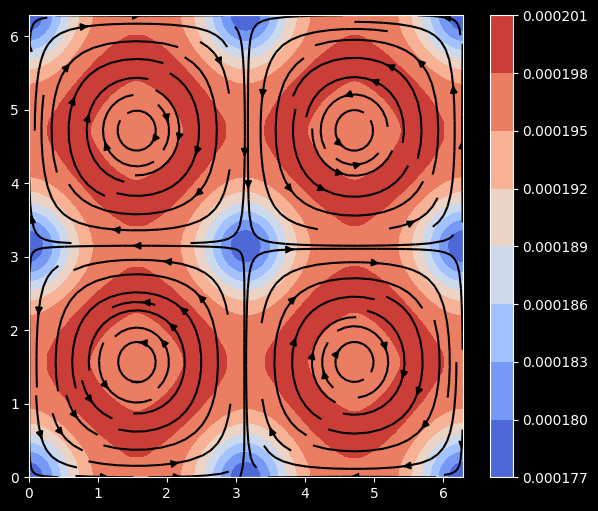

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

L = 2.*math.pi

res = np.load('res_0000032000.npz')
r = res['U']
u = res['U']
v = res['V']
p = res['P']
u_exact = res['U_exact']
v_exact = res['V_exact']
p_exact = res['P_exact']

HX = L / p.shape[0];
HY = L / p.shape[1];

#p[:,:] -= 1.

x = np.linspace(0.0, L, p.shape[0])
y = np.linspace(0.0, L, p.shape[1])

X, Y = np.meshgrid(x, y)

t = 20.
NU = 0.01


# p_exact = np.zeros_like(X)
# u_exact = np.zeros_like(X)
# v_exact = np.zeros_like(X)

#u_exact =  np.cos(X) * np.sin(Y) * np.exp(-2. * NU * t)
#v_exact = -np.sin(X) * np.cos(Y) * np.exp(-2. * NU * t)
#p_exact = -0.25 * (np.cos(2. * X) + np.cos(2. * Y)) * np.exp(-4. * NU * t);

p_err = np.sqrt((p_exact-p)**2)*HX*HY
u_err = np.sqrt((u_exact-u)**2)*HX*HY
plt.style.use("dark_background")
plt.figure(figsize=(7,6))
plt.contourf(X[:, :], Y[:, :], p_err[:, :], cmap="coolwarm")
plt.colorbar()

#plt.quiver(X[::2, ::2], Y[::2, ::2], u_exact[::2, ::2], v_exact[::2, ::2], color="black")
plt.streamplot(X[:, :], Y[:, :], u[:, :], v[:, :], color="black")
# plt.streamplot(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
plt.xlim((0, L))
plt.ylim((0, L))
plt.show()



\begin{array}{|r|c|c|}
\hline
N & ||\cdot||_{L_2} & k \\
\hline
\hline
100 & 0.0031790033140832044 & - \\
\hline
200 & 0.0007945329197127201 & 2.0004 \\
\hline
400 & 0.00019862503047090565 &2.0001\\
\hline
\end{array}

$$
k = \log_2\left(\dfrac{||\varepsilon_{2N}||}{||\varepsilon_{N}||}\right)
$$


In [38]:
p_err.max()


0.0031790033140832044

In [44]:
p_err.max()

0.0007945329197127201

In [3]:
p_err.max()

0.00019862503047090565

In [5]:
import math

print(math.log(0.0031790033140832044/0.0007945329197127201)/math.log(2.))
print(math.log(0.0007945329197127201/0.00019862503047090565)/math.log(2.))


2.000395619673459
2.00005955479107
